In [139]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score
from sklearn.model_selection import cross_validate
from sklearn.utils import resample,shuffle
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix


pd.set_option("display.max_columns",500)

In [56]:
applied=pd.read_csv('./application_record.csv')
approved=pd.read_csv('./credit_record.csv')

In [57]:
lwr=[]
for x in applied.columns:
    lwr.append(x.lower())
applied.columns=lwr
fff=applied[['code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'amt_income_total', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type', 'days_birth',
       'days_employed', 'flag_mobil', 'flag_work_phone', 'flag_phone',
       'flag_email', 'occupation_type', 'cnt_fam_members']]
for f in fff.columns:
    print(fff[f].value_counts())

F    294440
M    144117
Name: code_gender, dtype: int64
N    275459
Y    163098
Name: flag_own_car, dtype: int64
Y    304074
N    134483
Name: flag_own_realty, dtype: int64
0     304071
1      88527
2      39884
3       5430
4        486
5        133
7          9
9          5
12         4
6          4
14         3
19         1
Name: cnt_children, dtype: int64
135000.0    46879
157500.0    39768
180000.0    37912
112500.0    36979
225000.0    34130
            ...  
300600.0        1
621000.0        1
109899.0        1
283185.0        1
83304.0         1
Name: amt_income_total, Length: 866, dtype: int64
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: name_income_type, dtype: int64
Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     31

In [58]:
cats=['code_gender', 'flag_own_car', 'flag_own_realty','name_income_type', 'name_education_type','name_family_status', 'name_housing_type','occupation_type']

In [132]:
cat_cols=pd.get_dummies(fff[cats],drop_first=False)
numers=list(set(fff.columns) - set(fff[cats].columns))
fin_df=pd.concat([applied['id'],fff[numers],cat_cols],axis=1)
fin_df


,id,flag_phone,days_employed,flag_work_phone,amt_income_total,cnt_children,days_birth,flag_mobil,cnt_fam_members,flag_email,code_gender_F,code_gender_M,flag_own_car_N,flag_own_car_Y,flag_own_realty_N,flag_own_realty_Y,name_income_type_Commercial associate,name_income_type_Pensioner,name_income_type_State servant,name_income_type_Student,name_income_type_Working,name_education_type_Academic degree,name_education_type_Higher education,name_education_type_Incomplete higher,name_education_type_Lower secondary,name_education_type_Secondary / secondary special,name_family_status_Civil marriage,name_family_status_Married,name_family_status_Separated,name_family_status_Single / not married,name_family_status_Widow,name_housing_type_Co-op apartment,name_housing_type_House / apartment,name_housing_type_Municipal apartment,name_housing_type_Office apartment,name_housing_type_Rented apartment,name_housing_type_With parents,occupation_type_Accountants,occupation_type_Cleaning staff,occupation_type_Cooking staff,occupation_type_Core staff,occupation_type_Drivers,occupation_type_HR staff,occupation_type_High skill tech staff,occupation_type_IT staff,occupation_type_Laborers,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Waiters/barmen staff
0,5008804,0,-4542,1,427500.0,0,-12005,1,2.0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5008805,0,-4542,1,427500.0,0,-12005,1,2.0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5008806,0,-1134,0,112500.0,0,-21474,1,2.0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,5008808,1,-3051,0,270000.0,0,-19110,1,1.0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,5008809,1,-3051,0,270000.0,0,-19110,1,1.0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,0,365243,0,135000.0,0,-22717,1,1.0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
438553,6840222,0,-3007,0,103500.0,0,-15939,1,1.0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
438554,6841878,0,-372,1,54000.0,0,-8169,1,1.0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
438555,6842765,0,365243,0,72000.0,0,-21673,1,2.0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


MONTHS_BALANCE	
Record month	
The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on


STATUS	
Status	
0: 1-29 days past due 
1: 30-59 days past due 
2: 60-89 days overdue 
3: 90-119 days overdue 
4: 120-149 days overdue 
5: Overdue or bad debts, write-offs for more than 150 days 
C: paid off that month 
X: No loan for the month

In [60]:
approved
lowr=[]
for x in approved.columns:
    lowr.append(x.lower())
approved.columns=lowr
approved['status'].value_counts()

'''
C    442031 Good
0    383120 Good
X    209230 Good
1     11090 Good
5      1693 Bad
2       868 Fair
3       320 Bad
4       223 Bad
'''
grp=approved.groupby(['id','status'])[['months_balance']].agg('count')
grp.reset_index(inplace=True)
bad_ids_1=grp[(grp['status']=='2')&(grp['months_balance']>2)]['id']
bad_ids_2=np.unique(approved[(approved['status']=='3')|(approved['status']=='4')|(approved['status']=='5')]['id'])
bad_ids_ttl=np.unique(list(bad_ids_1)+list(bad_ids_2))

In [134]:
fin_df['target']=np.where(fin_df['id'].isin(bad_ids_ttl),0,1)
fullx=fin_df[['cnt_fam_members', 'flag_phone', 'flag_mobil', 'days_employed',
       'amt_income_total', 'flag_work_phone', 'cnt_children', 'flag_email',
       'days_birth', 'code_gender_F', 'code_gender_M', 'flag_own_car_N',
       'flag_own_car_Y', 'flag_own_realty_N', 'flag_own_realty_Y',
       'name_income_type_Commercial associate', 'name_income_type_Pensioner',
       'name_income_type_State servant', 'name_income_type_Student',
       'name_income_type_Working', 'name_education_type_Academic degree',
       'name_education_type_Higher education',
       'name_education_type_Incomplete higher',
       'name_education_type_Lower secondary',
       'name_education_type_Secondary / secondary special',
       'name_family_status_Civil marriage', 'name_family_status_Married',
       'name_family_status_Separated',
       'name_family_status_Single / not married', 'name_family_status_Widow',
       'name_housing_type_Co-op apartment',
       'name_housing_type_House / apartment',
       'name_housing_type_Municipal apartment',
       'name_housing_type_Office apartment',
       'name_housing_type_Rented apartment', 'name_housing_type_With parents',
       'occupation_type_Accountants', 'occupation_type_Cleaning staff',
       'occupation_type_Cooking staff', 'occupation_type_Core staff',
       'occupation_type_Drivers', 'occupation_type_HR staff',
       'occupation_type_High skill tech staff', 'occupation_type_IT staff',
       'occupation_type_Laborers', 'occupation_type_Low-skill Laborers',
       'occupation_type_Managers', 'occupation_type_Medicine staff',
       'occupation_type_Private service staff',
       'occupation_type_Realty agents', 'occupation_type_Sales staff',
       'occupation_type_Secretaries', 'occupation_type_Security staff',
       'occupation_type_Waiters/barmen staff']]
fully=fin_df['target']

fin_df['target'].value_counts()
(326/438231)

0.0007438999066702264

In [125]:
len(fin_df)
tst_idx=np.random.choice(438557,87711,replace=False)
tst_idx
train_idx=list(set(fin_df.index)-set(tst_idx))
train_idx

test_full=shuffle(fin_df,n_samples=round(len(fin_df)*.2),random_state=0)

train_idx=list(set(fin_df.index) - set(test_full.index))

train_full=fin_df.iloc[train_idx]
good=train_full[train_full['target']==1]
to_res=train_full[train_full['target']==0]

resampled=resample(to_res,random_state=42,n_samples=35000,replace=True)

res_df=pd.concat((good,resampled),axis=0)
res_df

X_test=test_full[['id', 'flag_phone', 'days_employed', 'flag_work_phone','amt_income_total', 'cnt_children', 'days_birth', 'flag_mobil','cnt_fam_members', 'flag_email', 'code_gender_F', 'code_gender_M','flag_own_car_N', 'flag_own_car_Y', 'flag_own_realty_N','flag_own_realty_Y', 'name_income_type_Commercial associate','name_income_type_Pensioner', 'name_income_type_State servant','name_income_type_Student', 'name_income_type_Working','name_education_type_Academic degree','name_education_type_Higher education','name_education_type_Incomplete higher','name_education_type_Lower secondary','name_education_type_Secondary / secondary special','name_family_status_Civil marriage', 'name_family_status_Married','name_family_status_Separated','name_family_status_Single / not married', 'name_family_status_Widow','name_housing_type_Co-op apartment','name_housing_type_House / apartment','name_housing_type_Municipal apartment','name_housing_type_Office apartment','name_housing_type_Rented apartment', 'name_housing_type_With parents','occupation_type_Accountants', 'occupation_type_Cleaning staff','occupation_type_Cooking staff', 'occupation_type_Core staff','occupation_type_Drivers', 'occupation_type_HR staff','occupation_type_High skill tech staff', 'occupation_type_IT staff','occupation_type_Laborers', 'occupation_type_Low-skill Laborers','occupation_type_Managers', 'occupation_type_Medicine staff','occupation_type_Private service staff','occupation_type_Realty agents', 'occupation_type_Sales staff','occupation_type_Secretaries', 'occupation_type_Security staff','occupation_type_Waiters/barmen staff']]
y_test=test_full['target']

X_train=res_df[['id', 'flag_phone', 'days_employed', 'flag_work_phone','amt_income_total', 'cnt_children', 'days_birth', 'flag_mobil','cnt_fam_members', 'flag_email', 'code_gender_F', 'code_gender_M','flag_own_car_N', 'flag_own_car_Y', 'flag_own_realty_N','flag_own_realty_Y', 'name_income_type_Commercial associate','name_income_type_Pensioner', 'name_income_type_State servant','name_income_type_Student', 'name_income_type_Working','name_education_type_Academic degree','name_education_type_Higher education','name_education_type_Incomplete higher','name_education_type_Lower secondary','name_education_type_Secondary / secondary special','name_family_status_Civil marriage', 'name_family_status_Married','name_family_status_Separated','name_family_status_Single / not married', 'name_family_status_Widow','name_housing_type_Co-op apartment','name_housing_type_House / apartment','name_housing_type_Municipal apartment','name_housing_type_Office apartment','name_housing_type_Rented apartment', 'name_housing_type_With parents','occupation_type_Accountants', 'occupation_type_Cleaning staff','occupation_type_Cooking staff', 'occupation_type_Core staff','occupation_type_Drivers', 'occupation_type_HR staff','occupation_type_High skill tech staff', 'occupation_type_IT staff','occupation_type_Laborers', 'occupation_type_Low-skill Laborers','occupation_type_Managers', 'occupation_type_Medicine staff','occupation_type_Private service staff','occupation_type_Realty agents', 'occupation_type_Sales staff','occupation_type_Secretaries', 'occupation_type_Security staff','occupation_type_Waiters/barmen staff']]
y_train=res_df['target']

y_train.value_counts()

1    350574
0     35000
Name: target, dtype: int64

In [144]:
X=fin_df[['cnt_fam_members', 'flag_phone', 'flag_mobil', 'days_employed','amt_income_total', 'flag_work_phone', 'cnt_children', 'flag_email','days_birth', 'code_gender_F', 'code_gender_M', 'flag_own_car_N','flag_own_car_Y', 'flag_own_realty_N', 'flag_own_realty_Y','name_income_type_Commercial associate', 'name_income_type_Pensioner','name_income_type_State servant', 'name_income_type_Student','name_income_type_Working', 'name_education_type_Academic degree','name_education_type_Higher education','name_education_type_Incomplete higher','name_education_type_Lower secondary','name_education_type_Secondary / secondary special','name_family_status_Civil marriage', 'name_family_status_Married','name_family_status_Separated','name_family_status_Single / not married', 'name_family_status_Widow','name_housing_type_Co-op apartment','name_housing_type_House / apartment','name_housing_type_Municipal apartment','name_housing_type_Office apartment','name_housing_type_Rented apartment', 'name_housing_type_With parents','occupation_type_Accountants', 'occupation_type_Cleaning staff','occupation_type_Cooking staff', 'occupation_type_Core staff','occupation_type_Drivers', 'occupation_type_HR staff','occupation_type_High skill tech staff', 'occupation_type_IT staff','occupation_type_Laborers', 'occupation_type_Low-skill Laborers','occupation_type_Managers', 'occupation_type_Medicine staff','occupation_type_Private service staff','occupation_type_Realty agents', 'occupation_type_Sales staff','occupation_type_Secretaries', 'occupation_type_Security staff','occupation_type_Waiters/barmen staff']]
y=fin_df['target']

X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=.2,stratify=y)

In [148]:
logistic=LogisticRegression(solver='newton-cg',class_weight='balanced')
logistic.fit(X_tr,y_tr)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

LogisticRegression(class_weight='balanced', solver='newton-cg')

In [151]:
print(logistic.score(X_tr,y_tr))
print(logistic.score(X_te,y_te))
print(f1_score(logistic.predict(X_tr),y_tr))
print(f1_score(logistic.predict(X_te),y_te))

0.6459262637346976
0.6443702116016052
0.7847549871520083
0.7836268668104852


In [152]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_tr, y_tr)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


NameError: name 'sns' is not defined

In [217]:
weights={0:672.633436,1:0.500372}
weights
lr=LogisticRegression(class_weight={0:672.633436,1:0.500372})
lr.fit(X_tr,y_tr)
lr.score(X_tr,y_tr)
f1_score(y_tr,lr.predict(X_tr))
confusion_matrix(y_tr,lr.predict(X_tr))
# lr.score(X_tr,y_tr,sample_weight=[1-0.044824,0.044824])
# print(gridsearch.best_estimator_.score(X_tr,y_tr))
# print(f1_score(y_tr,gridsearch.best_estimator_.predict(X_tr)))

# print(gridsearch.best_estimator_.score(X_te,y_te))
# print(f1_score(y_te,gridsearch.best_estimator_.predict(X_te)))
# confusion_matrix(y_te,gridsearch.best_estimator_.predict(X_te))

array([[   130,    131],
       [153343, 197241]])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,score,weight
0,0.999628,1.000000
1,0.999628,0.995025
2,0.999628,0.990050
3,0.999628,0.985075
4,0.999628,0.980101
...,...,...
188,0.999628,0.064724
189,0.999628,0.059749
190,0.999628,0.054774
191,0.999628,0.049799


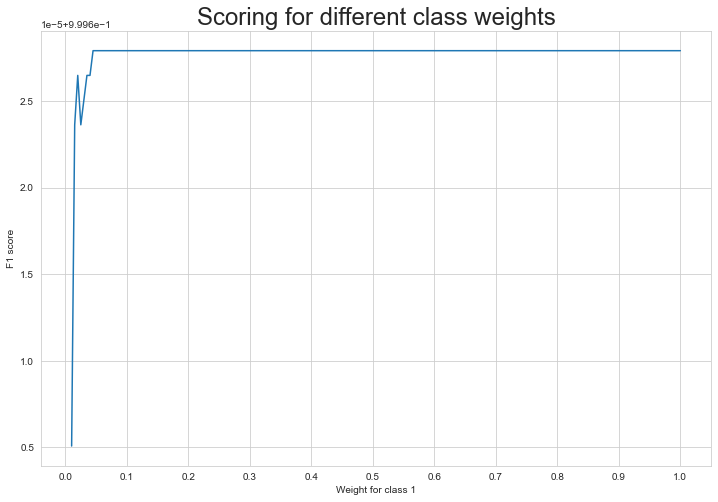

In [165]:
import seaborn as sns
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

weigh_data[weigh_data['score']==0.9996279024595435]

In [209]:
from sklearn.utils.class_weight import compute_sample_weight

pd.Series(compute_sample_weight(class_weight='balanced',y=fin_df['target'])).value_counts()

0.500372      438231
672.633436       326
dtype: int64

In [126]:
logit=LogisticRegression(solver='saga',penalty='elasticnet',max_iter=100)
params={'l1_ratio':[0,.001,.01,.1,.25,.5,.75,1]}
logit_cv=GridSearchCV(logit,param_grid=params)

In [137]:
log_reg=LogisticRegression(class_weight='balanced')
log_reg.fit(X_train,y_train)#,sample_weight=0.0007438999066702264)

LogisticRegression(class_weight='balanced')

In [141]:
print(log_reg.score(X_train,y_train))
print(log_reg.score(X_test,y_test))
print(confusion_matrix(y_train,log_reg.predict(X_train)))
print(confusion_matrix(y_test,log_reg.predict(X_test)))

0.7056103367965683
0.7153606731196771
[[ 22538  12462]
 [101047 249527]]
[[   36    18]
 [24948 62709]]


In [143]:
f1_score(y_test,log_reg.predict(X_test))
accuracy_score(y_test,log_reg.predict(X_test))
# confusion_matrix(y_test,log_reg.predict(X_test))


0.7153606731196771

In [69]:
logit.predict(X_train)
logit.predict(X_test)

print(recall_score(logit.predict(X_train),y_train))
print(precision_score(logit.predict(X_train),y_train))

print(recall_score(logit.predict(X_test),y_test))
print(precision_score(logit.predict(X_test),y_test))

0.5202293717963079
0.7683037446089953
0.5195203311043504
0.7676360856618024


In [70]:
len(res_df['target'][res_df['target']==1])/len(res_df['target'])

0.5

In [72]:
confusion_matrix(y_test,logit.predict(X_test))

array([[25421, 62225],
       [20366, 67281]])

In [73]:
y_train.value_counts()

0    350585
1    350584
Name: target, dtype: int64

In [74]:
confusion_matrix(y_train,logit.predict(X_train))

array([[102178, 248407],
       [ 81229, 269355]])

In [76]:
cross_validate(logit,X,y,cv=10)

{'fit_time': array([1.09626698, 1.01069093, 1.07661581, 1.12596202, 1.12552595,
        1.02719903, 1.18192887, 1.34463406, 1.25243211, 1.29227686]),
 'score_time': array([0.00890398, 0.00774407, 0.00813413, 0.00938416, 0.00836682,
        0.00903988, 0.0122962 , 0.00815988, 0.01134682, 0.00865889]),
 'test_score': array([0.53270506, 0.52498089, 0.52295598, 0.54150788, 0.53549506,
        0.52566004, 0.53300778, 0.53402323, 0.52267074, 0.52599092])}

AttributeError: 'dict' object has no attribute 'summary'